# Ghost Ads
In this exercise we are going to study the difference between the two methods of Random Controlled Trials on advertising effectiveness: 
Please read this first: https://www.thinkwithgoogle.com/intl/en-gb/marketing-resources/data-measurement/a-revolution-in-measuring-ad-effectiveness/

More specifically, we will study whether the claim about the 'ghost ad' method having a much higher power than the 'intend to treat' method, as said by Lewis in this video: https://www.youtube.com/watch?v=_do6ACKKlnw
He claims this is especially true when only targeting a small subgroup of the total population.

### Don't forget to select your venv interpreter!
Install all the packages in the first cell

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy

In [2]:
from IPython.display import Latex, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, norm

## Creating the data set
The population has two types of people, buyers and non-buyers. In the Ghost ads example the buyers would be the 'striped T-shirt people' who are the only ones interested in the advertised product. Non-buyers have zero probability of buying your product, whether they were exposed to your ad or not. The buyers (striped T-shirts) have a probability of buying when not exposed to ads (take for example 0.2) and a sligthly higher probability when they are exposed to ads (take for example 0.3). Also, the bidding algorithm doesn't always correctly identify a buyer (as can be seen in the picture below), so add a probability of misclassification (for example 0.1).
![True Population](GhostAds_1._Ideal_experiment_FINAL_v2.png)

In [3]:
def misclassify(is_buyer, p_misclassified):
    if is_buyer == 1:
        x = bernoulli.rvs(p=1-p_misclassified)
    else:
        x = bernoulli.rvs(p=p_misclassified)
    return x

def conversion(is_buyer, is_predicted_buyer, is_treatment,
              p_conversion_buyer_exposed, p_conversion_buyer_non_exposed,
              p_conversion_non_buyer):
    if is_buyer == 1 and is_predicted_buyer == 1 and is_treatment == 1:
        x = bernoulli.rvs(p=p_conversion_buyer_exposed)
    elif is_buyer == 1:
        x = bernoulli.rvs(p=p_conversion_buyer_non_exposed)
    else:
        x = bernoulli.rvs(p=p_conversion_non_buyer)
    return x

misclassify = np.vectorize(misclassify)
conversion = np.vectorize(conversion)

def create_data(p_conversion_buyer_non_exposed = 0.2, 
                p_conversion_buyer_exposed = 0.3, 
                p_conversion_non_buyer = 0,
                p_is_buyer = 0.5,
                p_treatment = 0.5,
                p_misclassified = 0.1, 
                n = 1000):
    x_buyers = bernoulli.rvs(size=n, p=p_is_buyer)
    x_predicted_buyers = misclassify(x_buyers, p_misclassified)
    x_treatment = bernoulli.rvs(size=n, p=p_treatment)
    conversions = conversion(x_buyers, x_predicted_buyers, x_treatment,
                              p_conversion_buyer_exposed, p_conversion_buyer_non_exposed,
                              p_conversion_non_buyer)
    return pd.DataFrame({'conversions':conversions,
                        'buyers': x_buyers,
                        'predicted_buyers': x_predicted_buyers,
                        'treatment': x_treatment})

In [4]:
data = create_data()
print(data.describe())

       conversions       buyers  predicted_buyers    treatment
count  1000.000000  1000.000000       1000.000000  1000.000000
mean      0.125000     0.504000          0.503000     0.491000
std       0.330884     0.500234          0.500241     0.500169
min       0.000000     0.000000          0.000000     0.000000
25%       0.000000     0.000000          0.000000     0.000000
50%       0.000000     1.000000          1.000000     0.000000
75%       0.000000     1.000000          1.000000     1.000000
max       1.000000     1.000000          1.000000     1.000000


## Create a function to perform the t-test

In [5]:
def run_t_test(users_a, users_b, converted_a, converted_b):
    p_a_hat = converted_a / users_a
    p_b_hat = converted_b / users_b
    var_p_a_hat = p_a_hat * (1-p_a_hat)
    var_p_b_hat = p_b_hat * (1-p_b_hat)
    t_stat = (p_b_hat - p_a_hat) / np.power((var_p_a_hat/users_a + var_p_b_hat/users_b), 0.5)
    p_val = norm.cdf(t_stat)
    return p_val

## Intend-to-treat
Intend to treat splits the population in control and treatment, before anything else. The conversions of the control and treatment group are then compared an tested for significant results.
![Intend to Treat](GhostAds_3._Intend_to_treat_FINAL_v2.png)

## Create a function that generates the results of the intend to treat method based on the created data set. The result should be similar to this:

|   	|count|sum|   	|   	|
|---	|---	|---	|---	|---	|
|treatment   	|   	|   	|   	|   	|
|0   	|533|53|   	|   	|
|1   	|467|68|   	|   	|

In [6]:
def create_intend_to_treat_data(p_conversion_buyer_non_exposed = 0.2, 
                p_conversion_buyer_exposed = 0.3, 
                p_conversion_non_buyer = 0,
                p_is_buyer = 0.5,
                p_treatment = 0.5,
                p_misclassified = 0.1, 
                n = 1000):
    data = create_data(p_conversion_buyer_non_exposed, 
                    p_conversion_buyer_exposed, 
                    p_conversion_non_buyer,
                    p_is_buyer,
                    p_treatment,
                    p_misclassified, 
                    n)
    return data.groupby(['treatment'])['conversions'].agg(['count', 'sum'])

print(create_intend_to_treat_data())

           count  sum
treatment            
0            506   53
1            494   84


## Ghost ads
With ghost ads, you actually do know who would have been exposed. So in the picture below, comparing the two green groups instead of the total treatment and control groups. The idea is that the power is much stronger with this method, so let's research this.
![True Population](GhostAds_1._Ideal_experiment_FINAL_v2.png)

## Create a function that generates the results of the ghst ads method based on the created data set. The result should be similar to this:

|   	|count|sum|   	|   	|
|---	|---	|---	|---	|---	|
|treatment   	|   	|   	|   	|   	|
|0   	|231|43|   	|   	|
|1   	|244|68|   	|   	|

In [7]:
def create_ghost_ads_data(p_conversion_buyer_non_exposed = 0.2, 
                p_conversion_buyer_exposed = 0.3, 
                p_conversion_non_buyer = 0,
                p_is_buyer = 0.5,
                p_treatment = 0.5,
                p_misclassified = 0.1, 
                n = 1000):
    data = create_data(p_conversion_buyer_non_exposed, 
                    p_conversion_buyer_exposed, 
                    p_conversion_non_buyer,
                    p_is_buyer,
                    p_treatment,
                    p_misclassified, 
                    n)
    return data[data['predicted_buyers'] == 1].groupby(['treatment'])['conversions'].agg(['count', 'sum'])

print(create_ghost_ads_data())

           count  sum
treatment            
0            239   53
1            243   57


## Run the analysis
Now you have everything ready to start analysis. Run simulations with different methods and calculate the power of both tests.
* Try for different sample sizes $N$
* Try for different size of 'buyer' groups by changing p_is_buyer
* Try for different rates of misclassification p_misclassified

0.6525
0.5775
0.835
0.7625
0.9175
0.8825
0.97
0.9325


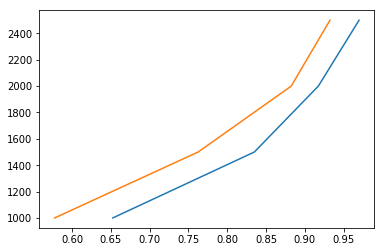

In [9]:
SIMULATIONS = 400
p_is_buyer = 0.5
p_misclassified = 0.1
alpha = 0.05

Ns = [1000, 1500, 2000, 2500]


ghost_ad_effects = []
ghost_ad_conversion_effects = []
ghost_ad_powers = []

intend_to_treat_effects = []
intend_to_treat_conversion_effects = []
intend_to_treat_powers = []

def run_simulations_for_n(N):
    
    # collect ghost ad results
    test_results = []
    treatment_effects = []

    for i in range(SIMULATIONS):
        data = create_ghost_ads_data(n=N, p_is_buyer=p_is_buyer, p_misclassified=p_misclassified)
        treatment_effects += [data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']]
        test_results += [run_t_test(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'])]

    ghost_ad_effect = np.array(treatment_effects).mean()
    ghost_ad_conversion_effect = np.array(treatment_effects).mean() * p_is_buyer * N
    ghost_ad_power = np.mean(np.array(test_results)>(1-alpha/2))
    
    
    # collect intend to treat results
    test_results = []
    treatment_effects = []
    
    for i in range(SIMULATIONS):
        data = create_intend_to_treat_data(n=N, p_is_buyer=p_is_buyer, p_misclassified=p_misclassified)
        treatment_effects += [data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']]
        test_results += [run_t_test(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'])]
    
    intend_to_treat_effect = np.array(treatment_effects).mean()
    intend_to_treat_conversion_effect = np.array(treatment_effects).mean() * N
    intend_to_treat_power = np.mean(np.array(test_results)>(1-alpha/2))
    
    return ghost_ad_effect, ghost_ad_conversion_effect, ghost_ad_power, \
            intend_to_treat_effect, intend_to_treat_conversion_effect, intend_to_treat_power
    
for N in Ns:
    ghost_ad_effect, ghost_ad_conversion_effect, ghost_ad_power, \
            intend_to_treat_effect, intend_to_treat_conversion_effect, intend_to_treat_power \
        = run_simulations_for_n(N)
    
    print(ghost_ad_power)
    print(intend_to_treat_power)
    
    ghost_ad_effects += [ghost_ad_effect]
    ghost_ad_conversion_effects += [ghost_ad_conversion_effect]
    ghost_ad_powers += [ghost_ad_power]

    intend_to_treat_effects += [intend_to_treat_effect]
    intend_to_treat_conversion_effects += [intend_to_treat_conversion_effect]
    intend_to_treat_powers += [intend_to_treat_power]
    
plt.plot(ghost_ad_powers, Ns)
plt.plot(intend_to_treat_powers, Ns)
plt.show()

0.695
0.6
0.7925
0.72
0.8425
0.74
0.89
0.8
0.93
0.86
0.95
0.915
0.9625
0.9


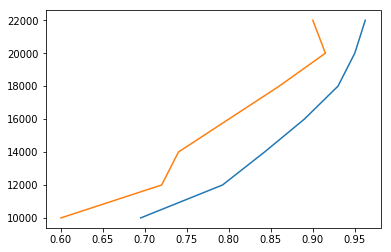

In [24]:
SIMULATIONS = 400
p_is_buyer = 0.05
p_misclassified = 0.01
alpha = 0.05

Ns = [10000, 12000, 14000, 16000, 18000, 20000, 22000]


ghost_ad_effects = []
ghost_ad_conversion_effects = []
ghost_ad_powers = []

intend_to_treat_effects = []
intend_to_treat_conversion_effects = []
intend_to_treat_powers = []

def run_simulations_for_n(N):
    
    # collect ghost ad results
    test_results = []
    treatment_effects = []

    for i in range(SIMULATIONS):
        data = create_ghost_ads_data(n=N, p_is_buyer=p_is_buyer, p_misclassified=p_misclassified)
        treatment_effects += [data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']]
        test_results += [run_t_test(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'])]

    ghost_ad_effect = np.array(treatment_effects).mean()
    ghost_ad_conversion_effect = np.array(treatment_effects).mean() * p_is_buyer * N
    ghost_ad_power = np.mean(np.array(test_results)>(1-alpha/2))
    
    
    # collect intend to treat results
    test_results = []
    treatment_effects = []
    
    for i in range(SIMULATIONS):
        data = create_intend_to_treat_data(n=N, p_is_buyer=p_is_buyer, p_misclassified=p_misclassified)
        treatment_effects += [data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']]
        test_results += [run_t_test(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'])]
    
    intend_to_treat_effect = np.array(treatment_effects).mean()
    intend_to_treat_conversion_effect = np.array(treatment_effects).mean() * N
    intend_to_treat_power = np.mean(np.array(test_results)>(1-alpha/2))
    
    return ghost_ad_effect, ghost_ad_conversion_effect, ghost_ad_power, \
            intend_to_treat_effect, intend_to_treat_conversion_effect, intend_to_treat_power
    
for N in Ns:
    ghost_ad_effect, ghost_ad_conversion_effect, ghost_ad_power, \
            intend_to_treat_effect, intend_to_treat_conversion_effect, intend_to_treat_power \
        = run_simulations_for_n(N)
    
    print(ghost_ad_power)
    print(intend_to_treat_power)
    
    ghost_ad_effects += [ghost_ad_effect]
    ghost_ad_conversion_effects += [ghost_ad_conversion_effect]
    ghost_ad_powers += [ghost_ad_power]

    intend_to_treat_effects += [intend_to_treat_effect]
    intend_to_treat_conversion_effects += [intend_to_treat_conversion_effect]
    intend_to_treat_powers += [intend_to_treat_power]
    
plt.plot(ghost_ad_powers, Ns)
plt.plot(intend_to_treat_powers, Ns)
plt.show()

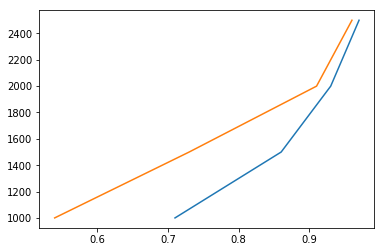

In [19]:
plt.plot(ghost_ad_powers, Ns)
plt.plot(intend_to_treat_powers, Ns)
plt.show()

In [11]:
print(ghost_ad_effects)
print(intend_to_treat_effects)
print(ghost_ad_conversion_effects)
print(intend_to_treat_conversion_effects)

[0.08914895694176113, 0.08940755483964642, 0.0892709077645687, 0.09060407358525588]
[0.043499447305951504, 0.04439625355063532, 0.045926021167931534, 0.0443711818568541]
[44.574478470880564, 67.05566612973482, 89.27090776456869, 113.25509198156985]
[43.499447305951506, 66.59438032595298, 91.85204233586308, 110.92795464213525]


## Use post hoc power calculation method

In [2]:
print(norm.ppf(1-0.05/2))

1.959963984540054


In [9]:
def run_t_test_with_power(users_a, users_b, converted_a, converted_b, alpha):
    p_a_hat = converted_a / users_a
    p_b_hat = converted_b / users_b
    var_p_a_hat = p_a_hat * (1-p_a_hat)
    var_p_b_hat = p_b_hat * (1-p_b_hat)
    diff = p_b_hat - p_a_hat
    diff_std_rerror = np.power((var_p_a_hat/users_a + var_p_b_hat/users_b), 0.5)
    t_stat = diff / diff_std_rerror
    p_val = norm.cdf(t_stat)
    sign_bound = norm.ppf(1-alpha/2) * diff_std_rerror
    power = 1 - norm.cdf(sign_bound, loc=diff, scale=diff_std_rerror)
    return p_val, power

def create_data_all_data(p_conversion_buyer_non_exposed = 0.2, 
                p_conversion_buyer_exposed = 0.3, 
                p_conversion_non_buyer = 0,
                p_is_buyer = 0.5,
                p_treatment = 0.5,
                p_misclassified = 0.1, 
                n = 1000):
    data = create_data(p_conversion_buyer_non_exposed, 
                    p_conversion_buyer_exposed, 
                    p_conversion_non_buyer,
                    p_is_buyer,
                    p_treatment,
                    p_misclassified, 
                    n)
    intend_to_treat_data = data.groupby(['treatment'])['conversions'].agg(['count', 'sum'])
    ghost_ad_data = data[data['predicted_buyers'] == 1].groupby(['treatment'])['conversions'].agg(['count', 'sum'])
    
    return intend_to_treat_data, ghost_ad_data

0.6397569892640597
0.5696138217080168
0.7645924319324103
0.6965317370039509
0.8512328612749422
0.7849253598914919
0.9148753051740883
0.8640301919824708


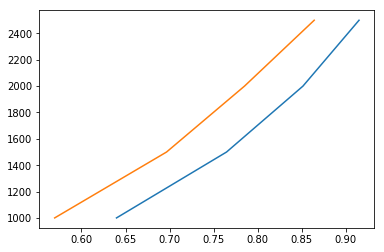

In [48]:
SIMULATIONS = 400
p_is_buyer = 0.5
p_misclassified = 0.1
alpha = 0.05

Ns = [1000, 1500, 2000, 2500]

# SIMULATIONS = 400
# p_is_buyer = 0.05
# p_misclassified = 0.01
# alpha = 0.05

# Ns = [10000, 12000, 14000, 16000, 18000, 20000, 22000]


ghost_ad_effects = []
ghost_ad_conversion_effects = []
ghost_ad_powers = []

intend_to_treat_effects = []
intend_to_treat_conversion_effects = []
intend_to_treat_powers = []

def run_simulations_for_n(N, SIMULATIONS):
    
    ghost_ad_treatment_effects = []
    ghost_ad_powers = []
    intend_to_treat_treatment_effects = []
    intend_to_treat_powers = []
    
    for i in range(SIMULATIONS):
        intend_to_treat_data, ghost_ad_data = create_data_all_data(n=N, p_is_buyer=p_is_buyer, 
                                                          p_misclassified=p_misclassified)
        data = ghost_ad_data
        ghost_ad_treatment_effect = data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']
        test_result, ghost_ad_power = run_t_test_with_power(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'], alpha)

        data = intend_to_treat_data
        intend_to_treat_treatment_effect = data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']
        test_result, intend_to_treat_power = run_t_test_with_power(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'], alpha)
    
        ghost_ad_treatment_effects += [ghost_ad_treatment_effect]
        ghost_ad_powers += [ghost_ad_power]
        intend_to_treat_treatment_effects += [intend_to_treat_treatment_effect]
        intend_to_treat_powers += [intend_to_treat_power]
    
    ghost_ad_treatment_effect = np.mean(ghost_ad_treatment_effects)
    ghost_ad_power = np.mean(ghost_ad_powers)
    intend_to_treat_treatment_effect = np.mean(intend_to_treat_treatment_effects)
    intend_to_treat_power = np.mean(intend_to_treat_powers)

    return ghost_ad_treatment_effect, ghost_ad_power, intend_to_treat_treatment_effect, intend_to_treat_power
    

for N in Ns:
    ghost_ad_treatment_effect, ghost_ad_power, intend_to_treat_treatment_effect, intend_to_treat_power \
    = run_simulations_for_n(N, SIMULATIONS)
    
    ghost_ad_effects += [ghost_ad_treatment_effect]
    ghost_ad_conversion_effects += [ghost_ad_treatment_effect * p_is_buyer * N]
    ghost_ad_powers += [ghost_ad_power]     
    intend_to_treat_effects += [intend_to_treat_treatment_effect]
    intend_to_treat_conversion_effects += [intend_to_treat_treatment_effect * N]
    intend_to_treat_powers += [intend_to_treat_power]
    
    print(ghost_ad_power)
    print(intend_to_treat_power)                        
                        
plt.plot(ghost_ad_powers, Ns)
plt.plot(intend_to_treat_powers, Ns)
plt.show()                        

0.6434846056637561
0.577722142188165
0.737791862389061
0.6578133111065907
0.7670956873026824
0.6749409532116911
0.7935311506642003
0.7134459130540581
0.8324274726947233
0.7546633668179594
0.8651914858387879
0.8030390938053439
0.8949776200793507
0.8384321088791273


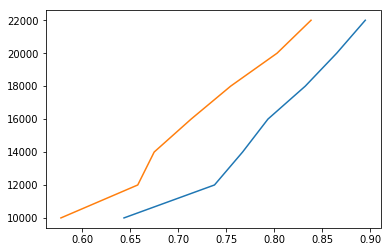

In [10]:
SIMULATIONS = 400
p_is_buyer = 0.05
p_misclassified = 0.01
alpha = 0.05

Ns = [10000, 12000, 14000, 16000, 18000, 20000, 22000]

# SIMULATIONS = 400
# p_is_buyer = 0.05
# p_misclassified = 0.01
# alpha = 0.05

# Ns = [10000, 12000, 14000, 16000, 18000, 20000, 22000]


ghost_ad_effects = []
ghost_ad_conversion_effects = []
ghost_ad_powers = []

intend_to_treat_effects = []
intend_to_treat_conversion_effects = []
intend_to_treat_powers = []

def run_simulations_for_n(N, SIMULATIONS):
    
    ghost_ad_treatment_effects = []
    ghost_ad_powers = []
    intend_to_treat_treatment_effects = []
    intend_to_treat_powers = []
    
    for i in range(SIMULATIONS):
        intend_to_treat_data, ghost_ad_data = create_data_all_data(n=N, p_is_buyer=p_is_buyer, 
                                                          p_misclassified=p_misclassified)
        data = ghost_ad_data
        ghost_ad_treatment_effect = data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']
        test_result, ghost_ad_power = run_t_test_with_power(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'], alpha)

        data = intend_to_treat_data
        intend_to_treat_treatment_effect = data.loc[1, 'sum']/data.loc[1, 'count'] - \
                                data.loc[0, 'sum']/data.loc[0, 'count']
        test_result, intend_to_treat_power = run_t_test_with_power(data.loc[0, 'count'], data.loc[1, 'count'],
                        data.loc[0, 'sum'], data.loc[1, 'sum'], alpha)
    
        ghost_ad_treatment_effects += [ghost_ad_treatment_effect]
        ghost_ad_powers += [ghost_ad_power]
        intend_to_treat_treatment_effects += [intend_to_treat_treatment_effect]
        intend_to_treat_powers += [intend_to_treat_power]
    
    ghost_ad_treatment_effect = np.mean(ghost_ad_treatment_effects)
    ghost_ad_power = np.mean(ghost_ad_powers)
    intend_to_treat_treatment_effect = np.mean(intend_to_treat_treatment_effects)
    intend_to_treat_power = np.mean(intend_to_treat_powers)

    return ghost_ad_treatment_effect, ghost_ad_power, intend_to_treat_treatment_effect, intend_to_treat_power
    

for N in Ns:
    ghost_ad_treatment_effect, ghost_ad_power, intend_to_treat_treatment_effect, intend_to_treat_power \
    = run_simulations_for_n(N, SIMULATIONS)
    
    ghost_ad_effects += [ghost_ad_treatment_effect]
    ghost_ad_conversion_effects += [ghost_ad_treatment_effect * p_is_buyer * N]
    ghost_ad_powers += [ghost_ad_power]     
    intend_to_treat_effects += [intend_to_treat_treatment_effect]
    intend_to_treat_conversion_effects += [intend_to_treat_treatment_effect * N]
    intend_to_treat_powers += [intend_to_treat_power]
    
    print(ghost_ad_power)
    print(intend_to_treat_power)                        
                        
plt.plot(ghost_ad_powers, Ns)
plt.plot(intend_to_treat_powers, Ns)
plt.show()                        